In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import keras.backend as K
import keras.layers as layers
from keras.models import Model
from keras.utils import to_categorical

Using TensorFlow backend.


In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pyjet import cluster,DTYPE_PTEPM
import pandas as pd

In [5]:
# use this cell to make a smaller input file for testing purposes

d = pd.DataFrame(np.load('../events_small.npy'))
d.shape
#d = pd.read_hdf("events.h5")
#np.save('events_small.npy', d[:800000])

(800000, 2101)

In [6]:
#d = pd.DataFrame(np.load('events_small.npy'))
#d.shape

In [7]:
# masks for bg and signal events
is_bg = (d[2100] == 0)
is_sig = (d[2100] == 1)

In [8]:
print("N_bg  = %d"%np.sum(is_bg))
print("N_sig = %d"%np.sum(is_sig))
print("N_tot = %d"%(np.sum(is_bg) + np.sum(is_sig)))

N_bg  = 727279
N_sig = 72721
N_tot = 800000


In [9]:
blah = np.array(d)

In [10]:
sig = [blah[i,:][:-1].reshape(700,3) for i in range(len(blah)) if blah[i,:][-1]==1]
bg = [blah[i,:][:-1].reshape(700,3) for i in range(len(blah)) if blah[i,:][-1]==0]

In [11]:
print(np.shape(sig))
print(np.shape(bg))

(72721, 700, 3)
(727279, 700, 3)


In [12]:
# Takes an input of shape (Nevt, Nparticle, 3), and returns a tuple (jets, consts):
# `jets` is a list containing the (pt, eta, phi, m) for the leading jet in each event
# `consts` is a list containing the (pt, eta, phi) for the leading `ntrk` particles in the jet.

def cluster_jets(evts, ntrk=16, pt_min=1600, gev=False, ntrk_min=None):
    ljets = np.zeros((len(evts), 4))
    consts = np.zeros((len(evts), ntrk, 3))
    
    if ntrk_min is None:
        ntrk_min = ntrk
    
    unit = 1e3 if gev else 1.0
    
    arr = np.zeros(700, dtype=DTYPE_PTEPM)
    for i,evt in enumerate(evts):
        pt = evt[:,0]
        mask = pt>0
        n = np.sum(mask)
        pt = pt[mask]
        eta = evt[:,1][mask]
        phi = evt[:,2][mask]
        pj_input = arr[:n]
        pj_input['pT'] = pt*unit
        pj_input['eta'] = eta
        pj_input['phi'] = phi
        sequence = cluster(pj_input, R=1.0, p=-1)
        jets = sequence.inclusive_jets(ptmin=20)

        if len(jets) < 1:
            continue
        
        j0 = jets[0]
        
        
        c0 = j0.constituents_array()
        c0[::-1].sort()
        nc = min(c0.shape[0], ntrk)
        
        if c0.shape[0] < ntrk_min:
            continue
            
        ljets[i] = (j0.pt, j0.eta, j0.phi, j0.mass)
        
        consts[i][:nc,0] = c0[:nc]['pT']
        consts[i][:nc,1] = c0[:nc]['eta']
        consts[i][:nc,2] = c0[:nc]['phi']
        
    sel = ljets[:,0] > pt_min
    ljets = ljets[sel]
    consts = consts[sel]
    
    return ljets, consts

In [13]:
# cluster jets, requiring pT>1.6 TeV

ntrk = 32
pt_min = 1600

bg_jets, bg_consts = cluster_jets(bg, ntrk=ntrk, pt_min=pt_min)
sig_jets, sig_consts = cluster_jets(sig, ntrk=ntrk, pt_min=pt_min)

In [14]:
print(bg_consts.shape)
print(sig_consts.shape)

(84677, 32, 3)
(33588, 32, 3)


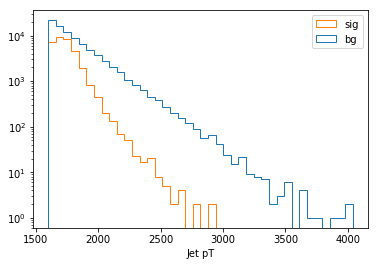

In [15]:
plt.hist([bg_jets[:,0], sig_jets[:,0]], histtype='step', bins=40, label=['bg','sig'])
plt.yscale('log')
plt.xlabel("Jet pT")
plt.legend();

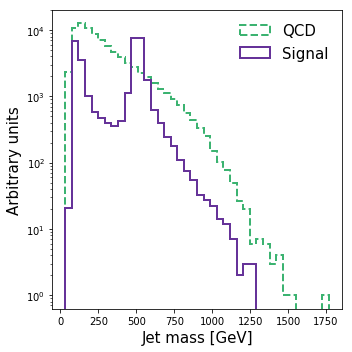

In [16]:
fig = plt.figure(figsize=(5,5))
n,b,_=plt.hist(bg_jets[:,3], histtype='step', bins=40, label=['QCD'],color='mediumseagreen',linestyle='--',linewidth=2.0)
plt.hist(sig_jets[:,3], histtype='step', bins=b, label=['Signal'],color='rebeccapurple',linewidth=2.0)
plt.yscale('log');
plt.xlabel("Jet mass [GeV]",fontsize=15)
plt.ylabel("Arbitrary units",fontsize=15)
plt.legend(fontsize=15,frameon=False);
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
fig.savefig("mJ.pdf");

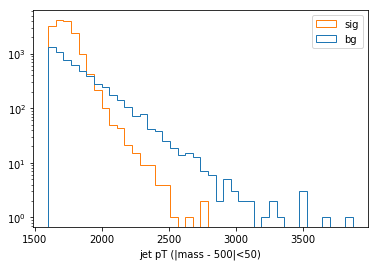

In [17]:
plt.hist([bg_jets[:,0][np.abs(bg_jets[:,3]-500)<50], sig_jets[:,0][np.abs(sig_jets[:,3]-500)<50]], histtype='step', bins=40, label=['bg','sig'])
plt.yscale('log');
plt.xlabel("jet pT (|mass - 500|<50)")
plt.legend();

In [18]:
# Format the dataset for input to the NN.
# First stack to together data from the two classes

nsig = len(sig_consts)
nbg = len(bg_consts)
ncls = min(nsig, nbg)

X = np.concatenate([bg_consts[:ncls], sig_consts[:ncls]], axis=0).copy()

# convert pT units to TeV (to limit range of inputs to NN)
X[:,:,0] /= 1000.

# make labels for bg (=0) and signal(=1)
y = np.zeros(X.shape[0], dtype=int)
y[ncls:] = 1

# randomly assign 85% of data to training sample, reserve the rest for validation
is_train = np.random.rand(X.shape[0])<0.85

X_train = X[is_train]
y_train = y[is_train]

X_val = X[~is_train]
y_val = y[~is_train]


# also make flipped labels for adversarial training
y_train_flipped = (y_train+1)%2
y_val_flipped = (y_val+1)%2

In [19]:
print("ncls =",ncls)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

ncls = 33588
(57165, 32, 3)
(57165,)
(10011, 32, 3)
(10011,)


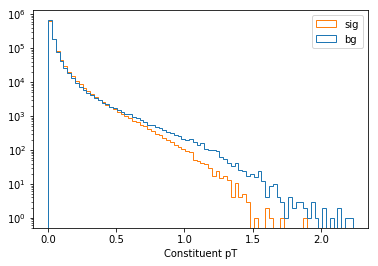

In [20]:
plt.hist([X[y==0][:,:,0].flatten(), X[y==1][:,:,0].flatten()],histtype='step',bins=80, label=['bg','sig']);
plt.yscale('log')
plt.xlabel('Constituent pT')
plt.legend();

In [21]:
# build and return three keras NN models: (classifier, adv, composed)
# The classifier takes `ntrk` constituents from a leading jet, and outputs [0,1]
# The adversary takes `ntrk` constituents, and outputs the same shape with the 4-vectors perturbed
# The composed model is the result of the classifier applied to adversary outputs, i.e. output=adv(cls(input))

def mylambda(x):
    return tf.nn.relu(x)

def mk_model(ntrk, dropout=0.25):
    K.clear_session()
    
    classifier_input = layers.Input((ntrk,3))
    
    H = classifier_input
    
    H = layers.Flatten()(H)
    
    for _ in range(2):
        H = layers.Dense(128, activation='relu')(H)
        if dropout:
            H = layers.Dropout(dropout)(H)
    
    H = layers.Dense(2, activation='softmax')(H)
    
    classifier = Model(classifier_input, H)
    
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    adv_input = layers.Input((ntrk,3))
    H = adv_input
    
    
    pt = layers.Lambda(lambda x: x[:,:,0:1])(H)
    eta = layers.Lambda(lambda x: x[:,:,1:2])(H)
    phi = layers.Lambda(lambda x: x[:,:,2:3])(H)
    
    
    pt_reg_weight = K.variable(1.0)
    def pt_reg(pt_weights):
        return pt_reg_weight*K.sum(K.square(pt_weights))
    
    eta_reg_weight = K.variable(1.0)
    def eta_reg(eta_weights):
        return eta_reg_weight*K.sum(K.square(eta_weights))
    
    phi_reg_weight = K.variable(1.0)
    def phi_reg(phi_weights):
        return phi_reg_weight*K.sum(K.square(phi_weights))
    
    H = layers.Flatten()(H)
    
    H = layers.Dense(256, activation='relu')(H)
    H = layers.Dense(256, activation='relu')(H)
    
    delta_pt = layers.Dense(ntrk, activation=None, activity_regularizer=pt_reg)(H)
    delta_pt = layers.Reshape((-1,1))(delta_pt)
    
    delta_eta = layers.Dense(ntrk, activation=None, activity_regularizer=eta_reg)(H)
    delta_eta = layers.Reshape((-1,1))(delta_eta)
    
    delta_phi = layers.Dense(ntrk, activation=None, activity_regularizer=phi_reg)(H)
    delta_phi = layers.Reshape((-1,1))(delta_phi)
    
    
    pt_new = layers.Lambda(lambda x: x[0]+x[1])([pt, delta_pt])
    #pt_new = layers.ReLU()(pt_new)
    pt_new = layers.Lambda(mylambda)(pt_new)
    #model.add(Lambda(mylambda))
    
    eta_new = layers.Lambda(lambda x: x[0]+x[1])([eta, delta_eta])
    
    phi_new = layers.Lambda(lambda x: x[0]+x[1])([phi, delta_phi])
    
    adv_output = layers.Concatenate()([pt_new,eta_new,phi_new])
    
    adv = Model(adv_input, adv_output)
    
    comp_input = layers.Input((ntrk,3))
    comp_output = classifier(adv(comp_input))
    comp = Model(comp_input, comp_output)
    
    comp.pt_reg_weight = pt_reg_weight
    comp.eta_reg_weight = eta_reg_weight
    comp.phi_reg_weight = phi_reg_weight
    
    classifier.trainable = False
    comp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    classifier.trainable = True
    
    return classifier, adv, comp

In [22]:
classifier, adv, comp = mk_model(ntrk)

classifier.summary()
adv.summary()

# NB you need to set the classifier weights to be untrainable when using the composed model.
classifier.trainable=False
comp.summary()
classifier.trainable=True

classifier_losses = []
classifier_val_losses = []
classifier_acc = []
classifier_val_acc = []

adv_losses = []
adv_val_losses = []
adv_acc = []
adv_val_acc = []

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 3)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total para

In [24]:
save_weights = False
load_weights = True

if save_weights:
    print("saving weights")
    classifier.save_weights('classifier_weights.h5')
if load_weights:
    print("loading weights")
    classifier.load_weights('classifier_weights.h5')

loading weights


## Train a simple signal/bg classifier

In [38]:
# train the signal classifier first
epochs = 10
batch_size = 128 #64

lr = 4e-4

K.set_value(classifier.optimizer.lr, lr)

try:
    classifier.fit(X_train, to_categorical(y_train,2),
              validation_data=(X_val, to_categorical(y_val,2)),
              batch_size=batch_size, epochs=epochs)
except KeyboardInterrupt:
    pass

classifier_losses.extend(classifier.history.history['loss'])
classifier_val_losses.extend(classifier.history.history['val_loss'])
classifier_acc.extend(classifier.history.history['acc'])
classifier_val_acc.extend(classifier.history.history['val_acc'])

Train on 57165 samples, validate on 10011 samples
Epoch 1/10
57165/57165 [==============================] - 3s 53us/step - loss: 0.5364 - acc: 0.7296 - val_loss: 0.5425 - val_acc: 0.7256
Epoch 2/10
57165/57165 [==============================] - 3s 53us/step - loss: 0.5320 - acc: 0.7321 - val_loss: 0.5405 - val_acc: 0.7265
Epoch 3/10
57165/57165 [==============================] - 3s 53us/step - loss: 0.5326 - acc: 0.7329 - val_loss: 0.5493 - val_acc: 0.7184
Epoch 4/10
57165/57165 [==============================] - 3s 55us/step - loss: 0.5321 - acc: 0.7331 - val_loss: 0.5408 - val_acc: 0.7262
Epoch 5/10
57165/57165 [==============================] - 3s 54us/step - loss: 0.5316 - acc: 0.7334 - val_loss: 0.5424 - val_acc: 0.7259
Epoch 6/10
57165/57165 [==============================] - 3s 54us/step - loss: 0.5296 - acc: 0.7336 - val_loss: 0.5389 - val_acc: 0.7233
Epoch 7/10
57165/57165 [==============================] - 3s 53us/step - loss: 0.5291 - acc: 0.7348 - val_loss: 0.5417 - val_acc

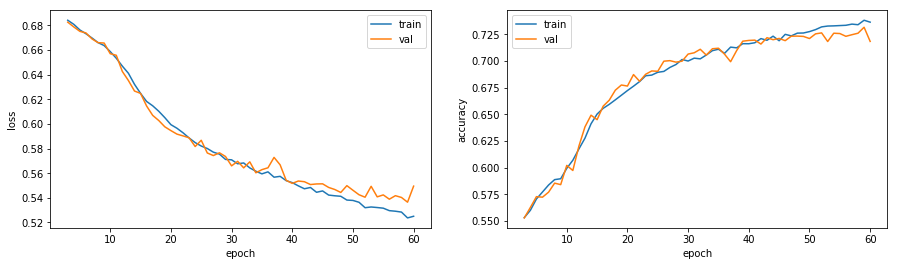

In [39]:
xstart = 2

xepochs = np.arange(len(classifier_losses))+1

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(xepochs[xstart:], classifier_losses[xstart:], label='train')
plt.plot(xepochs[xstart:], classifier_val_losses[xstart:], label='val')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend();

plt.subplot(122)
plt.plot(xepochs[xstart:], classifier_acc[xstart:], label='train')
plt.plot(xepochs[xstart:], classifier_val_acc[xstart:], label='val')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

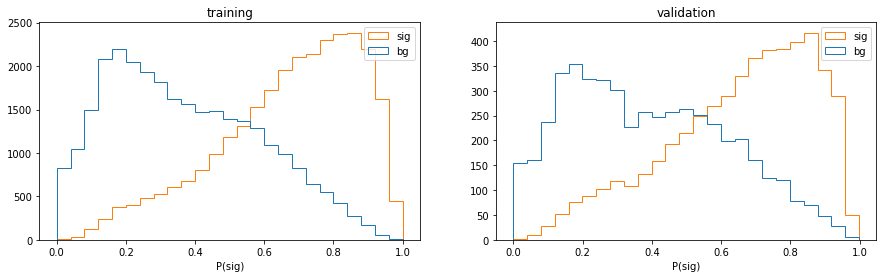

In [40]:
plt.figure(figsize=(15,4))

hargs = dict(histtype='step', bins=25, label=['bg','sig'])

plt.subplot(121)
plt.hist([classifier.predict(X_train[y_train==0])[:,1], classifier.predict(X_train[y_train==1])[:,1]], **hargs)
plt.xlabel("P(sig)")
plt.title("training")
plt.legend();

plt.subplot(122)
plt.hist([classifier.predict(X_val[y_val==0])[:,1], classifier.predict(X_val[y_val==1])[:,1]], **hargs)
plt.xlabel("P(sig)")
plt.title("validation")
plt.legend();

In [41]:
xvals0 = classifier.predict(X_train[y_train==0])[:,1]
yvals0 = classifier.predict(X_train[y_train==1])[:,1]

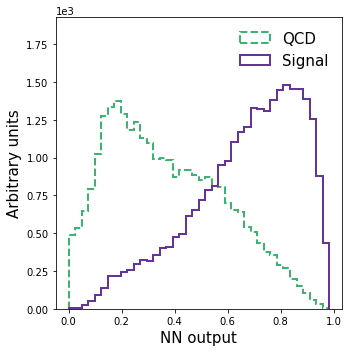

In [51]:
fig = plt.figure(figsize=(5,5))
n,b,_=plt.hist(xvals0, histtype='step', bins=40, label=['QCD'],color='mediumseagreen',linestyle='--',linewidth=2.0)
n2,b2,_=plt.hist(yvals0, histtype='step', bins=b, label=['Signal'],color='rebeccapurple',linewidth=2.0)
#plt.yscale('log');
plt.xlabel("NN output",fontsize=15)
plt.ylabel("Arbitrary units",fontsize=15)
plt.legend(fontsize=15,frameon=False);
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylim([0.,1.3*max([max(n2),max(n)])])
plt.tight_layout()
fig.savefig("NN.pdf");

In [52]:
classifier.evaluate(X_val, to_categorical(y_val,2))

10011/10011 [==============================] - 0s 34us/step


[0.5494650730766648, 0.7185096394502489]

In [53]:
classifier.evaluate(X_val[y_val==0], to_categorical(y_val[y_val==0],2))

4961/4961 [==============================] - 0s 34us/step


[0.5953705668257168, 0.6690183430759927]

In [54]:
classifier.evaluate(X_val[y_val==1], to_categorical(y_val[y_val==1],2))

5050/5050 [==============================] - 0s 34us/step


[0.5043686077146247, 0.7671287128240756]

In [55]:
np.sum(y_val*1.)/len(y_val)

0.5044451103785835

## train an adversary to modify jet constituents to fool classifier

In [40]:
# Once the classifier is trained to a satisfactory level, we can freeze its weights
# and train to adversary, by training the composed model to maximize the opposite classification.
epochs = 10
batch_size = 128

lr = 1e-4

pt_reg_weight = 3e-2
phi_reg_weight = 3e-2
eta_reg_weight = 3e-2


K.set_value(comp.optimizer.lr, lr)
K.set_value(comp.pt_reg_weight, pt_reg_weight)

mode = 'flip' # one of ('flip', 'bg', 'signal'); the target output label for perturbed jets

if mode == 'flip':
    # completely switch labels
    y_train_target = y_train_flipped
    y_val_target = y_val_flipped
elif mode == 'bg':
    # train to output BG jets
    y_train_target = np.zeros_like(y_train)
    y_val_target = np.zeros_like(y_val)
elif mode == 'signal':
    # train to output BG jets
    y_train_target = np.ones_like(y_train)
    y_val_target = np.ones_like(y_val)
else:
    raise ValueError("Bad training mode")

classifier.trainable = False
try:
    comp.fit(X_train, to_categorical(y_train_target, 2),
             validation_data=(X_val, to_categorical(y_val_target, 2)),
             batch_size=batch_size, epochs=epochs, verbose=2)
except KeyboardInterrupt:
    pass

classifier.trainable = True

adv_losses.extend(comp.history.history['loss'])
adv_val_losses.extend(comp.history.history['val_loss'])

adv_acc.extend(comp.history.history['acc'])
adv_val_acc.extend(comp.history.history['val_acc'])

Train on 57199 samples, validate on 9977 samples
Epoch 1/10
 - 4s - loss: 1.6831 - acc: 0.3473 - val_loss: 1.4900 - val_acc: 0.3499
Epoch 2/10
 - 4s - loss: 1.4319 - acc: 0.3480 - val_loss: 1.3241 - val_acc: 0.3455
Epoch 3/10
 - 4s - loss: 1.3037 - acc: 0.3486 - val_loss: 1.2341 - val_acc: 0.3492
Epoch 4/10
 - 4s - loss: 1.2356 - acc: 0.3487 - val_loss: 1.1806 - val_acc: 0.3497
Epoch 5/10
 - 4s - loss: 1.1946 - acc: 0.3505 - val_loss: 1.1459 - val_acc: 0.3510
Epoch 6/10
 - 4s - loss: 1.1717 - acc: 0.3453 - val_loss: 1.1248 - val_acc: 0.3464
Epoch 7/10
 - 4s - loss: 1.1571 - acc: 0.3464 - val_loss: 1.1078 - val_acc: 0.3508
Epoch 8/10
 - 4s - loss: 1.1483 - acc: 0.3462 - val_loss: 1.0977 - val_acc: 0.3501
Epoch 9/10
 - 4s - loss: 1.1414 - acc: 0.3450 - val_loss: 1.0914 - val_acc: 0.3525
Epoch 10/10
 - 4s - loss: 1.1380 - acc: 0.3477 - val_loss: 1.0871 - val_acc: 0.3522


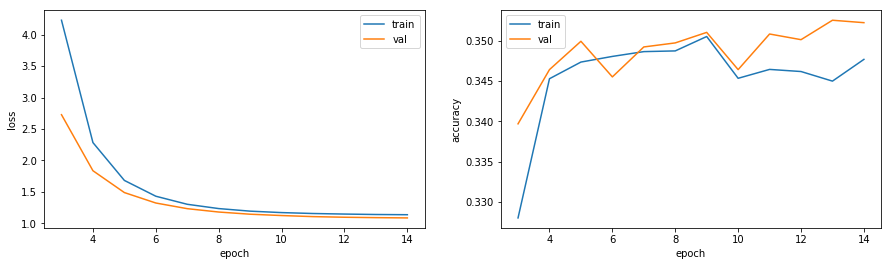

In [41]:
xstart = 2

xepochs = np.arange(len(adv_losses))+1

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(xepochs[xstart:], adv_losses[xstart:], label='train')
plt.plot(xepochs[xstart:], adv_val_losses[xstart:], label='val')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend();

plt.subplot(122)
plt.plot(xepochs[xstart:], adv_acc[xstart:], label='train')
plt.plot(xepochs[xstart:], adv_val_acc[xstart:], label='val')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [42]:
classifier.evaluate(X_val, to_categorical(y_val, 2))

9977/9977 [==============================] - 1s 74us/step


[0.531588766932595, 0.738598777205454]

In [43]:
classifier.evaluate(adv.predict(X_val), to_categorical(y_val, 2))

9977/9977 [==============================] - 1s 74us/step


[0.6289710588226747, 0.6477899168684019]

In [44]:
classifier.evaluate(adv.predict(X_val[y_val==0]), to_categorical(y_val[y_val==0], 2))

4982/4982 [==============================] - 0s 71us/step


[0.6057173921276124, 0.6971095946121293]

In [45]:
classifier.evaluate(adv.predict(X_val[y_val==1]), to_categorical(y_val[y_val==1], 2))

4995/4995 [==============================] - 0s 73us/step


[0.6521642026839194, 0.598598598604565]

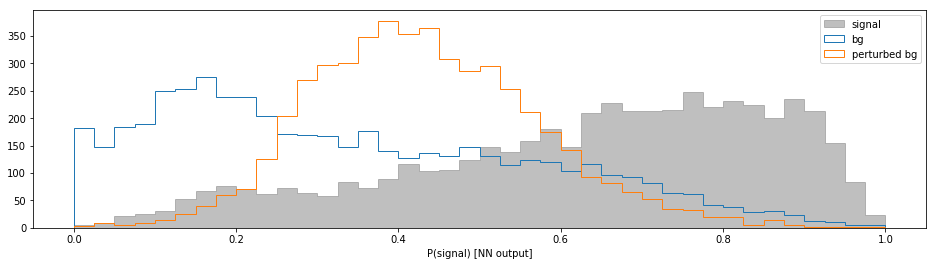

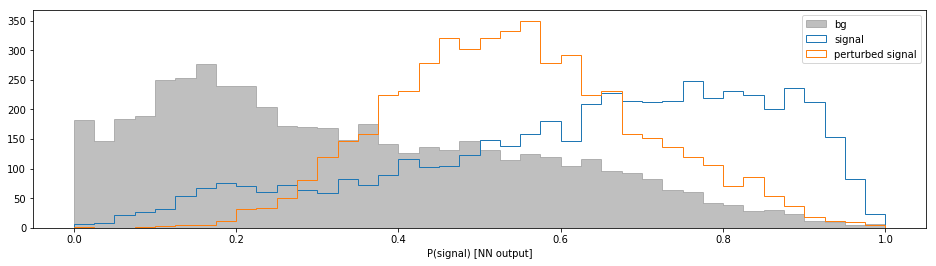

In [46]:
hargs = dict(histtype='step', bins=40, range=(0,1))

plt.figure(figsize=(16,4))
plt.hist(classifier.predict(X_val[y_val==1])[:,1], color='gray', fill=True, alpha=0.5, label='signal', **hargs);
plt.hist(classifier.predict(X_val[y_val==0])[:,1], label='bg', **hargs);
plt.hist(classifier.predict(adv.predict(X_val[y_val==0]))[:,1], label='perturbed bg', **hargs)
plt.xlabel("P(signal) [NN output]")
plt.legend();

plt.figure(figsize=(16,4))
plt.hist(classifier.predict(X_val[y_val==0])[:,1], color='gray', fill=True, alpha=0.5, label='bg', **hargs);
plt.hist(classifier.predict(X_val[y_val==1])[:,1], label='signal', **hargs);
plt.hist(classifier.predict(adv.predict(X_val[y_val==1]))[:,1], label='perturbed signal', **hargs)
plt.xlabel("P(signal) [NN output]")
plt.legend();

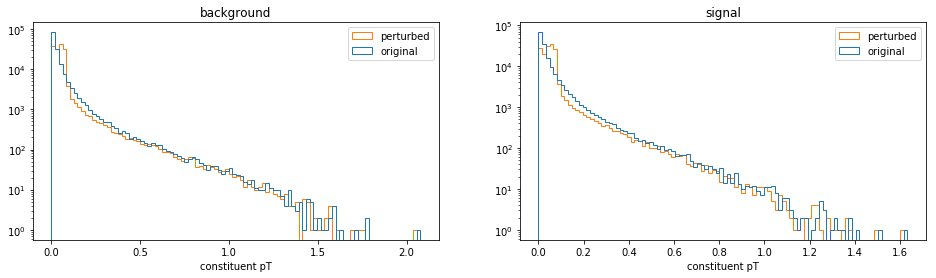

In [47]:
# plot the pT of the constituents before/after being perturbed by the adversary
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.hist([X_val[y_val==0][:,:,0].flatten(), adv.predict(X_val[y_val==0])[:,:,0].flatten()],
         bins=100, histtype='step', label=['original','perturbed']);
plt.yscale('log')
plt.xlabel("constituent pT")
plt.title("background")
plt.legend();

plt.subplot(122)
plt.hist([X_val[y_val==1][:,:,0].flatten(), adv.predict(X_val[y_val==1])[:,:,0].flatten()],
         bins=100, histtype='step', label=['original','perturbed']);
plt.yscale('log')
plt.xlabel("constituent pT")
plt.title("signal")
plt.legend();

In [48]:
jets_before = cluster_jets(X_val, ntrk=ntrk, pt_min=0, gev=True, ntrk_min=0)[0]
jets_after = cluster_jets(adv.predict(X_val), ntrk=ntrk, pt_min=0, gev=True, ntrk_min=0)[0]
assert jets_before.shape == jets_after.shape

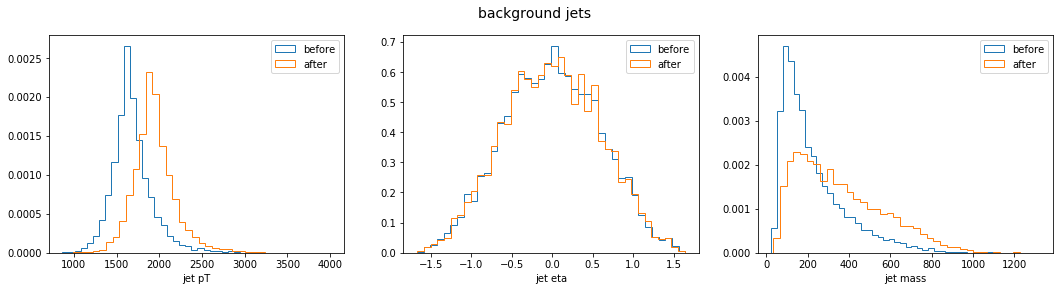

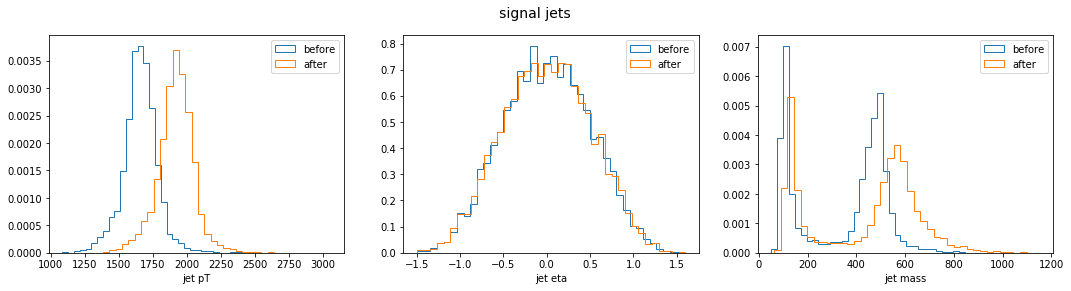

In [49]:
hargs = dict(histtype='step', bins=40, density=True)

plt.figure(figsize=(18,4))
plt.subplot(131)
plt.hist(jets_before[y_val==0][:,0], label='before', **hargs)
plt.hist(jets_after[y_val==0][:,0], label='after', **hargs)
plt.xlabel("jet pT")
plt.legend()
plt.subplot(132)
plt.hist(jets_before[y_val==0][:,1], label='before', **hargs)
plt.hist(jets_after[y_val==0][:,1], label='after', **hargs)
plt.xlabel("jet eta")
plt.legend()
plt.subplot(133)
plt.hist(jets_before[y_val==0][:,3], label='before', **hargs)
plt.hist(jets_after[y_val==0][:,3], label='after', **hargs)
plt.xlabel("jet mass")
plt.legend();
plt.suptitle("background jets", fontsize=14);

plt.figure(figsize=(18,4))
plt.subplot(131)
plt.hist(jets_before[y_val==1][:,0], label='before', **hargs)
plt.hist(jets_after[y_val==1][:,0], label='after', **hargs)
plt.xlabel("jet pT")
plt.legend()
plt.subplot(132)
plt.hist(jets_before[y_val==1][:,1], label='before', **hargs)
plt.hist(jets_after[y_val==1][:,1], label='after', **hargs)
plt.xlabel("jet eta")
plt.legend()
plt.subplot(133)
plt.hist(jets_before[y_val==1][:,3], label='before', **hargs)
plt.hist(jets_after[y_val==1][:,3], label='after', **hargs)
plt.xlabel("jet mass")
plt.legend();
plt.suptitle("signal jets", fontsize=14);

## per-event adversarial examples using FGSM

In [169]:
# pick a particular jet, and initialize the adversarial example with its values. also initialize the adversarial noise with zeros

njet = 6000
target_class = 1

use_sign = True

target_name = ['bg', 'signal'][target_class]
other_name = ['signal','bg'][target_class]

x = X_val[y_val==target_class][:njet]
x_adv = x.copy()
x_noise = np.zeros_like(x)

prediction_history     = [classifier.predict(x)[:,target_class].mean()]
prediction_history_quant = [np.percentile(classifier.predict(x)[:,target_class],100*np.array([0.5,0.68,0.95]))]

In [170]:
# Define the epsilons in the (pt, eta, phi) directions
#epsilons = (5e-5,5e-4,5e-4)
epsilons = (2e-4,2e-3,2e-3)
nstep = 10

# Then loop for the desired number of iterations to update the adversarial
# noise using the classifier loss gradient:

sess = K.get_session()
epsilon = K.reshape(K.constant(epsilons), (1,1,3))
for istep in range(nstep):
    print("FGSM %d/%d..."%(istep+1,nstep))
    loss = -1*K.categorical_crossentropy(to_categorical((target_class+1)%2,2), classifier.get_output_at(0))
    grads = K.gradients(loss, classifier.get_input_at(0))
    
    if use_sign:
        delta = K.sign(grads[0])
    else:
        delta = grads[0]
    x_noise = x_noise + delta
    
    x_adv = x_adv + epsilon*delta
    x_adv = sess.run(x_adv, feed_dict={classifier.get_input_at(0):x})
    preds = classifier.predict(x_adv)[:,target_class]
    prediction_history.append(preds.mean())
    prediction_history_quant.append(np.percentile(preds, 100*np.array([0.5,0.68,0.9])))
    print("  avg:", preds.mean())

FGSM 1/10...
  avg: 0.6331185
FGSM 2/10...
  avg: 0.6149809
FGSM 3/10...
  avg: 0.5971801
FGSM 4/10...
  avg: 0.57982457
FGSM 5/10...
  avg: 0.5630026
FGSM 6/10...
  avg: 0.5467615
FGSM 7/10...
  avg: 0.5310413
FGSM 8/10...
  avg: 0.515862
FGSM 9/10...
  avg: 0.5012451
FGSM 10/10...
  avg: 0.48718575


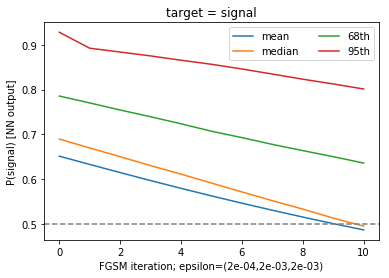

In [171]:
plt.plot(prediction_history, label='mean')
plt.plot(np.array(prediction_history_quant)[:,0], label='median')
plt.plot(np.array(prediction_history_quant)[:,1], label='68th')
plt.plot(np.array(prediction_history_quant)[:,2], label='95th')
plt.xlabel("FGSM iteration; epsilon=(%.e,%.e,%.e)"%epsilons)
plt.ylabel("P(%s) [NN output]"%target_name)
plt.title("target = %s"%target_name)
plt.axhline(0.5, ls='--', color='gray')
plt.legend(ncol=2);

In [195]:
classifier.evaluate(x_adv, to_categorical([target_class]*len(x_adv),2))

5050/5050 [==============================] - 0s 48us/step


[0.8082528750731214, 0.505544554408234]

'\nfig = plt.figure(figsize=(5,5))\nn,b,_=plt.hist(xvals0, histtype=\'step\', bins=40, label=[\'QCD\'],color=\'mediumseagreen\',linestyle=\'--\',linewidth=2.0)\nplt.hist(yvals0, histtype=\'step\', bins=b, label=[\'Signal\'],color=\'rebeccapurple\',linewidth=2.0)\n#plt.yscale(\'log\');\nplt.xlabel("NN output",fontsize=15)\nplt.ylabel("Arbitrary units",fontsize=15)\nplt.legend(fontsize=15,frameon=False);\nplt.ticklabel_format(style=\'sci\', axis=\'y\', scilimits=(0,0))\nplt.ylim([0.,1.2*max(n)])\nplt.tight_layout()\nfig.savefig("NN.pdf");\n'

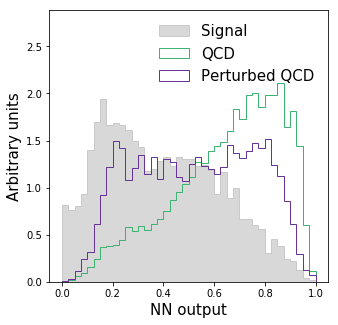

In [60]:
hargs = dict(histtype='step', bins=40, range=(0,1), density=True)

fig = plt.figure(figsize=(5,5))
#plt.figure(figsize=(8,4))
#plt.hist(classifier.predict(X_val[y_val!=target_class])[:,1], color='gray', fill='gray', alpha=0.3, label=other_name, **hargs)
#plt.hist(classifier.predict(x)[:,1], label='%s'%target_name, **hargs,color='mediumseagreen')
#plt.hist(classifier.predict(x_adv)[:,1], label='perturbed %s'%target_name, **hargs,color='rebeccapurple')
plt.hist(classifier.predict(X_val[y_val!=target_class])[:,1], color='gray', fill='gray', alpha=0.3, label='Signal', **hargs)
plt.hist(classifier.predict(x)[:,1], label='QCD', **hargs,color='mediumseagreen')
plt.hist(classifier.predict(x_adv)[:,1], label='Perturbed QCD', **hargs,color='rebeccapurple')
plt.xlabel("NN output",fontsize=15)
plt.ylabel("Arbitrary units",fontsize=15)
#plt.title("target: %s" % target_name)
plt.ylim(top=plt.ylim()[1]*1.3)
plt.legend(fontsize=15,frameon=False);
fig.savefig("NN_FGSM.pdf");

'''
fig = plt.figure(figsize=(5,5))
n,b,_=plt.hist(xvals0, histtype='step', bins=40, label=['QCD'],color='mediumseagreen',linestyle='--',linewidth=2.0)
plt.hist(yvals0, histtype='step', bins=b, label=['Signal'],color='rebeccapurple',linewidth=2.0)
#plt.yscale('log');
plt.xlabel("NN output",fontsize=15)
plt.ylabel("Arbitrary units",fontsize=15)
plt.legend(fontsize=15,frameon=False);
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylim([0.,1.2*max(n)])
plt.tight_layout()
fig.savefig("NN.pdf");
'''

In [167]:
# re-cluster the constituents to see if there's any effect on the jet-level kinematics:

jet_before = cluster_jets(x, ntrk=ntrk, pt_min=0, gev=True, ntrk_min=0)[0]
jet_after = cluster_jets(x_adv, ntrk=ntrk, pt_min=0, gev=True, ntrk_min=0)[0]

assert jet_before.shape == jet_after.shape

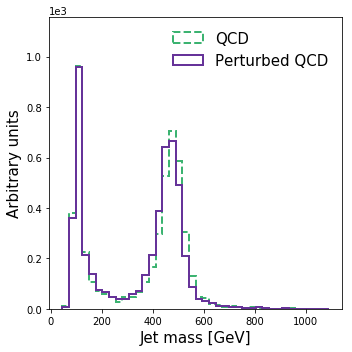

In [168]:
hargs = dict(histtype='step', bins=40, density=True)

'''
plt.figure(figsize=(18,4))
plt.subplot(131)
plt.hist(jet_before[:,0], label='before', **hargs)
plt.hist(jet_after[:,0], label='after', **hargs)
plt.xlabel("jet pT")
plt.legend()
plt.subplot(132)
plt.hist(jet_before[:,1], label='before', **hargs)
plt.hist(jet_after[:,1], label='after', **hargs)
plt.xlabel("jet eta")
plt.legend()
plt.subplot(133)
plt.hist(jet_before[:,3], label='before', **hargs)
plt.hist(jet_after[:,3], label='after', **hargs)
plt.xlabel("jet mass")
plt.legend();
plt.suptitle("target = %s" % target_name, fontsize=14);
'''

fig = plt.figure(figsize=(5,5))
n,b,_=plt.hist(jet_before[:,3], histtype='step', bins=40, label=['QCD'],color='mediumseagreen',linestyle='--',linewidth=2.0)
plt.hist(jet_after[:,3], histtype='step', bins=b, label=['Perturbed QCD'],color='rebeccapurple',linewidth=2.0)
#plt.yscale('log');
plt.xlabel("Jet mass [GeV]",fontsize=15)
plt.ylabel("Arbitrary units",fontsize=15)
plt.legend(fontsize=15,frameon=False);
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylim([0.,1.2*max(n)])
plt.tight_layout()
fig.savefig("JetMass_FGSM.pdf");

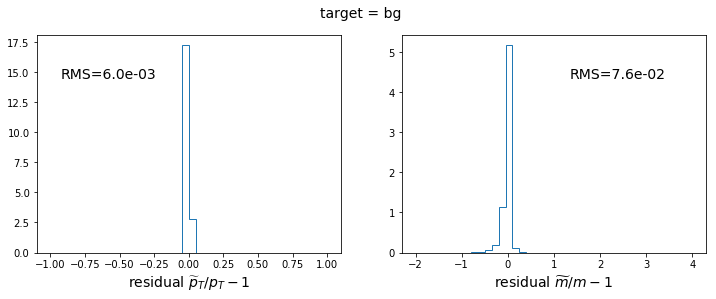

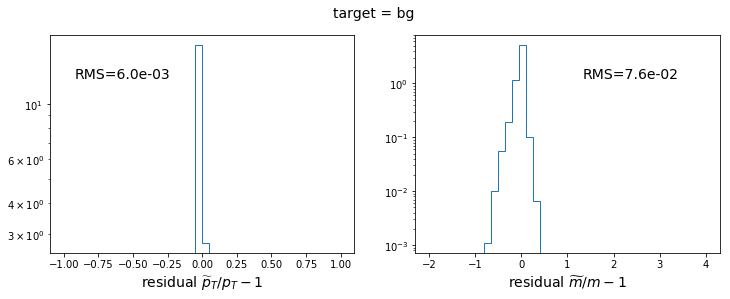

In [515]:
hargs = dict(histtype='step', bins=40, color='C0', density=True)

plt.figure(figsize=(12,4))

pt_pull = jet_after[:,0]/jet_before[:,0]-1
mass_pull = jet_after[:,3]/jet_before[:,3]-1

plt.subplot(121)
plt.hist(jet_after[:,0]/jet_before[:,0]-1, range=(-1,1), **hargs);
plt.xlabel(r"residual $\widetilde{p}_T/ p_T- 1$")
plt.text(0.08, 0.8, 'RMS=%.1e'%pt_pull.std(), fontsize=14, transform=plt.gca().transAxes)
plt.subplot(122)
plt.hist(jet_after[:,3]/jet_before[:,3]-1, range=(-2,4), **hargs);
plt.xlabel(r"residual $\widetilde{m} / m - 1$")
plt.text(0.55, 0.8, 'RMS=%.1e'%mass_pull.std(), fontsize=14, transform=plt.gca().transAxes);

plt.suptitle("target = %s"%target_name, fontsize=14)

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(jet_after[:,0]/jet_before[:,0]-1, range=(-1,1), **hargs);
plt.xlabel(r"residual $\widetilde{p}_T/ p_T- 1$")
plt.text(0.08, 0.8, 'RMS=%.1e'%pt_pull.std(), fontsize=14, transform=plt.gca().transAxes)
plt.yscale('log')
plt.subplot(122)
plt.hist(jet_after[:,3]/jet_before[:,3]-1, range=(-2,4), **hargs);
plt.xlabel(r"residual $\widetilde{m} / m - 1$")
plt.text(0.55, 0.8, 'RMS=%.1e'%mass_pull.std(), fontsize=14, transform=plt.gca().transAxes);
plt.yscale('log');
plt.suptitle("target = %s"%target_name, fontsize=14);

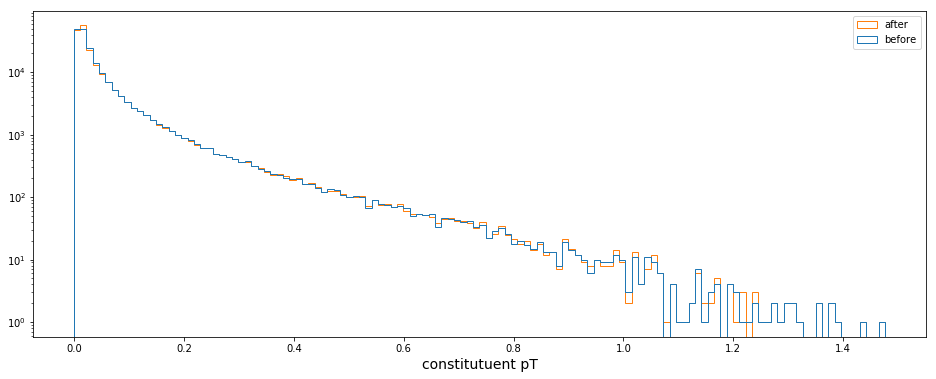

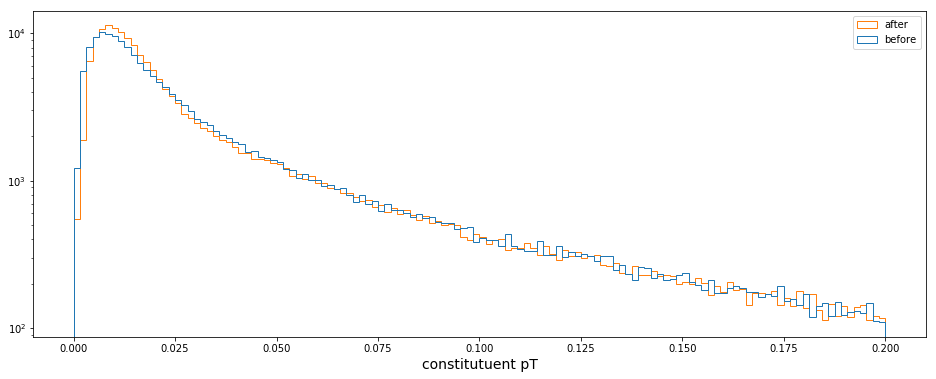

In [476]:
# plot the pT of the jet constituents before / after the adversarial perturbation
plt.figure(figsize=(16,6))
plt.hist([x[:,:,0].flatten(), x_adv[:,:,0].flatten()], histtype='step', bins=128, label=['before','after']);
plt.xlabel("constitutuent pT")
plt.yscale('log')
plt.legend();

plt.figure(figsize=(16,6))
plt.hist([x[:,:,0].flatten(), x_adv[:,:,0].flatten()], histtype='step', bins=128, range=(0,0.2), label=['before','after']);
plt.xlabel("constitutuent pT")
plt.yscale('log')
plt.legend();

In [57]:
#Let's make a jet image making function.
def make_image(input_jet):
    xvals = []
    yvals = []
    zvals = []
    for i in range(inpput_jet):
        xvals+=[input_jet[i][1]]
        yvals+=[input_jet[i][2]]
        zvals+=[input_jet[i][0]]
        pass
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=100, edgecolor='')
    plt.show()

2

In [62]:
import matplotlib

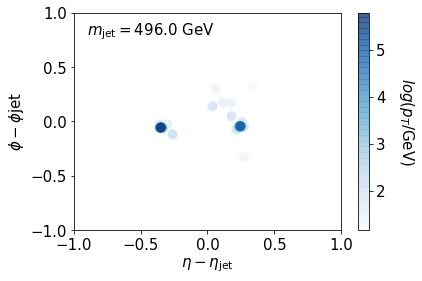

In [64]:
whichjet = 4
#input_jet=X_val[y_val==1][4]
input_jet = sig_consts[whichjet]

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
cm = plt.cm.get_cmap('Blues')
xvals = []
yvals = []
zvals = []
for i in range(len(input_jet)):
    ii = len(inpput_jet)-i-1
    xvals+=[input_jet[ii][1]-np.mean(input_jet[::,1])]
    yvals+=[input_jet[ii][2]-np.mean(input_jet[::,2])]
    zvals+=[np.log(input_jet[ii][0])]
    pass
fig, ax = plt.subplots()
sc = ax.scatter(xvals, yvals, c=zvals, s=100, edgecolor='',alpha=0.5,cmap=cm)
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])
plt.xlabel(r'$\eta-\eta_{\rm jet}$',fontsize=15)
plt.ylabel(r'$\phi-\phi{\rm jet}$',fontsize=15)
cbar = plt.colorbar(sc)
cbar.ax.get_yaxis().labelpad = 30
cbar.set_label(r'$log(p_{T}/{\rm GeV})$', rotation=270,fontsize=15)
plt.text(-0.9, 0.8, r'$m_{\rm jet}='+str(round(sig_jets[whichjet][3]))+'$ GeV', dict(size=15))
plt.show()

0.5308281926280232


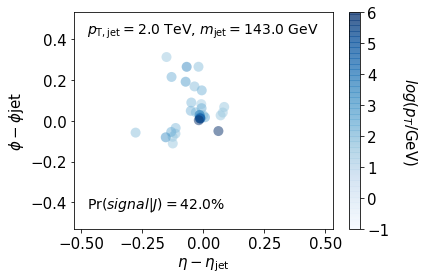

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in log


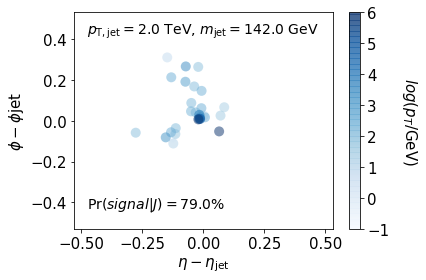

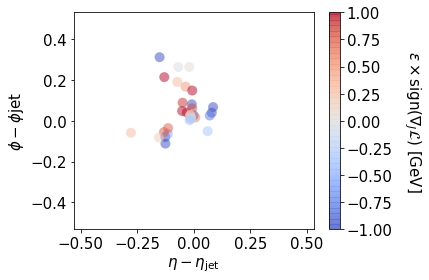

In [231]:
whichjet = 8 #8

#First, the unperturbed jet.
input_jet = x[whichjet]
jpt,jeta,jphi,jm = mymass_np(x[whichjet])

myrange = 1.7*max(max(abs(input_jet[:,1]-jeta)),max(abs(input_jet[:,2]-jphi)))
print(myrange)

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
cm = plt.cm.get_cmap('Blues')
xvals = []
yvals = []
zvals = []
for i in range(len(input_jet)):
    ii = len(input_jet)-i-1
    xvals+=[input_jet[ii][1]-jeta]
    yvals+=[input_jet[ii][2]-jphi]
    zvals+=[np.log(1000.*input_jet[ii][0])]
    pass
fig, ax = plt.subplots()
sc = ax.scatter(xvals, yvals, c=zvals, s=100, edgecolor='',alpha=0.5,cmap=cm,vmin=-1,vmax=6)
#plt.xlim([-1.0,1.0])
#plt.ylim([-1.0,1.0])
plt.xlim([-myrange,myrange])
plt.ylim([-myrange,myrange])
plt.xlabel(r'$\eta-\eta_{\rm jet}$',fontsize=15)
plt.ylabel(r'$\phi-\phi{\rm jet}$',fontsize=15)
cbar = plt.colorbar(sc)
cbar.ax.get_yaxis().labelpad = 30
cbar.set_label(r'$log(p_{T}/{\rm GeV})$', rotation=270,fontsize=15)
plt.text(-0.9*myrange, 0.8*myrange, '$p_{\\rm T,jet} ='+str(round(jpt))+'$ TeV, $m_{\\rm jet}='+str(round(1000*jm))+'$ GeV', dict(size=14))
plt.text(-0.9*myrange, -0.8*myrange, r'$\Pr(signal|J)='+str(round(100*classifier.predict(x)[whichjet][1]))+'\%$', dict(size=14))
plt.tight_layout()
plt.show()
fig.savefig('panel_1.pdf')

#Next, the perturbed jet.
input_jet = x_adv[whichjet]
jpt_a,jeta_a,jphi_a,jm_a = mymass_np(x_adv[whichjet])

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
cm = plt.cm.get_cmap('Blues')
xvals = []
yvals = []
zvals = []
for i in range(len(input_jet)):
    ii = len(input_jet)-i-1
    xvals+=[input_jet[ii][1]-jeta_a]
    yvals+=[input_jet[ii][2]-jphi_a]
    zvals+=[np.log(1000.*input_jet[ii][0])]
    pass
fig, ax = plt.subplots()
sc = ax.scatter(xvals, yvals, c=zvals, s=100, edgecolor='',alpha=0.5,cmap=cm,vmin=-1,vmax=6)
#plt.xlim([-1.0,1.0])
#plt.ylim([-1.0,1.0])
plt.xlim([-myrange,myrange])
plt.ylim([-myrange,myrange])
plt.xlabel(r'$\eta-\eta_{\rm jet}$',fontsize=15)
plt.ylabel(r'$\phi-\phi{\rm jet}$',fontsize=15)
cbar = plt.colorbar(sc)
cbar.ax.get_yaxis().labelpad = 30
cbar.set_label(r'$log(p_{T}/{\rm GeV})$', rotation=270,fontsize=15)
plt.text(-0.9*myrange, 0.8*myrange, '$p_{\\rm T,jet} ='+str(round(jpt_a))+'$ TeV, $m_{\\rm jet}='+str(round(1000*jm_a))+'$ GeV', dict(size=14))
plt.text(-0.9*myrange, -0.8*myrange, r'$\Pr(signal|J)='+str(round(100*classifier.predict(x_adv)[whichjet][1]))+'\%$', dict(size=14))
plt.tight_layout()
plt.show()
fig.savefig('panel_2.pdf')

#Now, let's try to visualize the noise.
input_jet = x_adv[whichjet]-x[whichjet]

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
cm = plt.cm.get_cmap('coolwarm')
xvals = []
yvals = []
zvals = []
for i in range(len(input_jet)):
    ii = len(input_jet)-i-1
    xvals+=[x[whichjet][ii][1]-jeta_a]
    yvals+=[x[whichjet][ii][2]-jphi_a]
    zvals+=[1000*input_jet[ii][0]] #100*input_jet[ii][0]/x[whichjet][ii][0]] #np.log(input_jet[ii][0])]
    #print(i,1000*x[whichjet][ii][0],[1000*input_jet[ii][0]]) #100*input_jet[ii][0]/x[whichjet][ii][0])
    pass
fig, ax = plt.subplots()
sc = ax.scatter(xvals, yvals, c=zvals, s=100, edgecolor='',alpha=0.5,cmap=cm,vmin=-1,vmax=1)
#plt.xlim([-1.0,1.0])
#plt.ylim([-1.0,1.0])
plt.xlim([-myrange,myrange])
plt.ylim([-myrange,myrange])
plt.xlabel(r'$\eta-\eta_{\rm jet}$',fontsize=15)
plt.ylabel(r'$\phi-\phi{\rm jet}$',fontsize=15)
cbar = plt.colorbar(sc)
cbar.ax.get_yaxis().labelpad = 30
#cbar.set_label(r'$\%$ Change', rotation=270,fontsize=15)
cbar.set_label(r'$\epsilon\times{\rm sign}(\nabla_J\mathcal{L})$ [GeV]', rotation=270,fontsize=15)
#plt.text(-0.9, 0.8, r'$m_{\rm jet}='+str(round(1000*mymass_np(x_adv[whichjet])[3]))+'$ GeV', dict(size=15))
#plt.text(-0.9, 0.6, r'$\Pr(signal|J)='+str(round(100*classifier.predict(x_adv)[whichjet][1]))+'\%$', dict(size=15))
plt.tight_layout()
plt.show()
fig.savefig('panel_3.pdf')

In [181]:
def mymass_np(input_x):
    #this one takes _consts without any modification.
    pT,eta,phi=np.split(input_x,3,axis=1)
    jpx = np.sum(pT*np.cos(phi))
    jpy = np.sum(pT*np.sin(phi))
    jpz = np.sum(pT*(0.5*(np.exp(eta)-np.exp(-eta))))
    jpE = np.sum(pT*(0.5*(np.exp(eta)+np.exp(-eta))))
    jpT = np.sqrt(jpx**2+jpy**2)
    jp = np.sqrt(jpT**2+jpz**2)
    jphi = np.math.atan2(jpy,jpx)
    jeta = np.math.acosh(jp/jpT)
    if (jpz < 0.):
        jeta*=-1
        pass    
    return jpT,jeta,jphi,np.sqrt(jpE**2-jpx**2-jpy**2-jpz**2)

In [75]:
def mymass_tensorflow(x):
    #this one takes _consts without any modification.
    pT,eta,phi=tf.split(x,3,axis=2) #axis = 2 because it is a list of particles, then a list of properties per particle
    jpx = K.sum(pT*tf.cos(phi),axis=1)
    jpy = K.sum(pT*tf.sin(phi),axis=1)
    jpz = K.sum(pT*(0.5*(tf.exp(eta)-tf.exp(-eta))),axis=1) #no tf.sinh in my version
    jpE = K.sum(pT*(0.5*(tf.exp(eta)+tf.exp(-eta))),axis=1) #no tf.cosh in my version
    return K.sqrt(jpE**2-jpx**2-jpy**2-jpz**2) #m
def mymass_numpy(x):
    #this one takes _consts without any modification.
    pT,eta,phi=np.split(x,3,axis=2) #axis = 2 because it is a list of particles, then a list of properties per particle
    jpx = np.sum(pT*np.cos(phi),axis=1)
    jpy = np.sum(pT*np.sin(phi),axis=1)
    jpz = np.sum(pT*(0.5*(np.exp(eta)-np.exp(-eta))),axis=1) #no tf.sinh in my version
    jpE = np.sum(pT*(0.5*(np.exp(eta)+np.exp(-eta))),axis=1) #no tf.cosh in my version
    return np.sqrt(jpE**2-jpx**2-jpy**2-jpz**2) #m

In [67]:
from keras import Sequential
from keras.layers import Lambda, Dense

In [68]:
model_massonly = Sequential()
model_massonly.add(Lambda(mymass_tensorflow,input_shape=(32,3),output_shape=(1,)))
model_massonly.add(Dense(80, activation='relu'))
model_massonly.add(Dense(40, activation='relu'))
model_massonly.add(Dense(20, activation='relu'))
model_massonly.add(Dense(2, activation='sigmoid'))
model_massonly.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_9 (Lambda)            (None, 1)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 80)                160       
_________________________________________________________________
dense_14 (Dense)             (None, 40)                3240      
_________________________________________________________________
dense_15 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 42        
Total params: 4,262
Trainable params: 4,262
Non-trainable params: 0
_________________________________________________________________


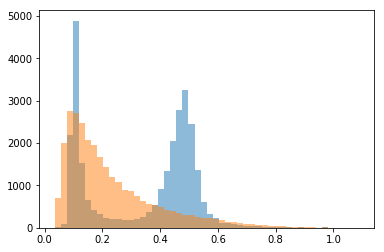

In [90]:
n,b,_=plt.hist(mymass_numpy(X_train)[y_train==1],alpha=0.5,bins=50)
n2,_,_=plt.hist(mymass_numpy(X_train)[y_train==0],alpha=0.5,bins=b)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


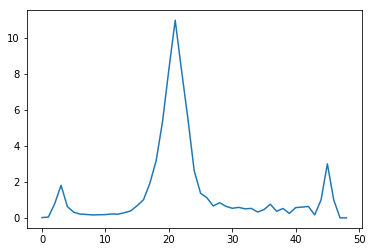

In [92]:
plt.plot(n/n2)

In [95]:
import itertools as it
def ecf_numpy(N, beta, x, normalized=False):
    pt = x[:,:,0]
    eta = x[:,:,1:2]
    phi = x[:,:,2:]

    if N == 0:
        return np.ones(x.shape[0])
    elif N == 1:
        if normalized:
            return np.ones(x.shape[0])
        else:
            return np.sum(pt, axis=-1)
    
    # pre-compute the R_ij matrix
    R = np.concatenate([np.sqrt((eta[:,i:i+1]-eta)**2+(phi[:,i:i+1]-phi)**2) for i in range(x.shape[1])], axis=-1)
    # note, if dR = 0, these are either diagonal or padded entries that will get killed by pT=0 terms.
    # set these entries to some positive number to avoid divide-by-zero when beta<0
    R = np.clip(R, 1e-6, 999)
    
    # and raise it to the beta power for use in the product expression
    R_beta = R**beta
    
    # indexing tensor, returns 1 if i>j>k...
    eps = np.zeros((x.shape[1],)*N)
    for idx in it.combinations(range(x.shape[1]), r=N):
        eps[idx] = 1
        
    if N == 2:
        result = np.einsum('ij,...i,...j,...ij',eps,pt,pt,R_beta)
    elif N == 3:
        result =  np.einsum('ijk,...i,...j,...k,...ij,...ik,...jk',eps,pt,pt,pt,R_beta,R_beta,R_beta)
    else:
        # just for fun, the general case...
        # use ascii chars a...z for einsum indices
        letters = [chr(asc) for asc in range(97,97+N)]
        idx_expression = ''.join(letters) +',' + ','.join('...%s'%c for c in letters)
        for a,b in it.combinations(letters, r=2):
            idx_expression += ',...%s%s'%(a,b)
        #print(idx_expression)
        args = (eps,) + (pt,)*N + (R_beta,)*(N*(N-1)//2)
        result = np.einsum(idx_expression, *args)

    if normalized:
        result = result / ecf_numpy(1,beta,x,normalized=False)**N

    return result

In [106]:
def ecf_tf(N, beta, x, normalized=False):
    pt = x[:,:,0]
    eta = x[:,:,1:2]
    phi = x[:,:,2:3]

    if N == 0:
        return tf.ones((x.shape[0],1))
    elif N == 1:
        if normalized:
            return tf.ones((x.shape[0],1))
        else:
            return tf.reduce_sum(pt, axis=-1, keepdims=True)
    
    # pre-compute the R_ij matrix
    R = tf.concat([tf.sqrt((eta[:,i:i+1]-eta)**2+(phi[:,i:i+1]-phi)**2) for i in range(x.shape[1])], axis=-1)
    # note, if dR = 0, these are either diagonal or padded entries that will get killed by pT=0 terms.
    # set these entries to some positive number to avoid divide-by-zero when beta<0
    R = tf.clip_by_value(R, 1e-6, 999)
    
    # and raise it to the beta power for use in the product expression
    R_beta = tf.pow(R,beta)
    
    # indexing tensor, returns 1 if i>j>k...
    eps = np.zeros((x.shape[1],)*N)
    for idx in it.combinations(range(x.shape[1]), r=N):
        eps[idx] = 1
    eps = tf.constant(eps, dtype=K.floatx())
        
    if N == 2:
        result = tf.einsum('ij,ai,aj,aij->a',eps,pt,pt,R_beta)
    elif N == 3:
        result = tf.einsum('ijk,ai,aj,ak,aij,aik,ajk->a',eps,pt,pt,pt,R_beta,R_beta,R_beta)
    else:
        # just for fun, the general case...
        # use ascii chars b...z for einsum indices ('a' is for the batch axis)
        letters = [chr(asc) for asc in range(98,98+N)]
        idx_expression = ''.join(letters) +',' + ','.join('a%s'%c for c in letters)
        for a,b in it.combinations(letters, r=2):
            idx_expression += ',a%s%s'%(a,b)
        idx_expression += '->a'
        #print(idx_expression)
        args = (eps,) + (pt,)*N + (R_beta,)*(N*(N-1)//2)
        result = tf.einsum(idx_expression, *args)

    if normalized:
        result = result / tf.pow(ecf_tf(1,beta,x,normalized=False), N)

    return tf.expand_dims(result, axis=-1)

In [96]:
ecf1 = ecf_numpy(1, 1, X_train, normalized=False)
ecf2 = ecf_numpy(2, 1, X_train, normalized=False)
ecf3 = ecf_numpy(3, 1, X_train, normalized=False)

In [99]:
d2 = ecf3 * pow(ecf1, 3) / pow(ecf2, 3)

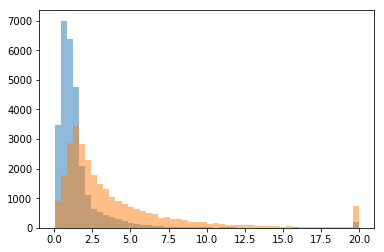

In [103]:
n,b,_=plt.hist(np.clip(d2[y_train==1],0,20),alpha=0.5,bins=50)
n2,_,_=plt.hist(np.clip(d2[y_train==0],0,20),alpha=0.5,bins=b)

(0, 25)

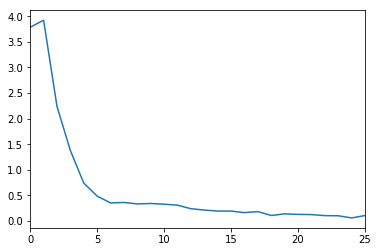

In [105]:
plt.plot(n/n2)
plt.xlim([0,25])

In [301]:
classifier_losses_massonly = []
classifier_val_losses_massonly = []
classifier_acc_massonly = []
classifier_val_acc_massonly = []

In [302]:
model_massonly.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_massonly.fit(X_train, to_categorical(y_train,2), epochs=10, batch_size=128,validation_data=(X_val, to_categorical(y_val,2)))
classifier_losses_massonly.extend(model_massonly.history.history['loss'])
classifier_val_losses_massonly.extend(model_massonly.history.history['val_loss'])
classifier_acc_massonly.extend(model_massonly.history.history['acc'])
classifier_val_acc_massonly.extend(model_massonly.history.history['val_acc'])

Train on 56948 samples, validate on 10228 samples
Epoch 1/10
56948/56948 [==============================] - 4s 65us/step - loss: 0.6219 - acc: 0.6804 - val_loss: 0.5905 - val_acc: 0.7105
Epoch 2/10
56948/56948 [==============================] - 2s 34us/step - loss: 0.5774 - acc: 0.7049 - val_loss: 0.5580 - val_acc: 0.7117
Epoch 3/10
56948/56948 [==============================] - 2s 33us/step - loss: 0.5563 - acc: 0.7027 - val_loss: 0.5501 - val_acc: 0.7095
Epoch 4/10
56948/56948 [==============================] - 2s 34us/step - loss: 0.5510 - acc: 0.7038 - val_loss: 0.5503 - val_acc: 0.7092
Epoch 5/10
56948/56948 [==============================] - 2s 33us/step - loss: 0.5468 - acc: 0.7052 - val_loss: 0.5434 - val_acc: 0.7114
Epoch 6/10
56948/56948 [==============================] - 2s 33us/step - loss: 0.5443 - acc: 0.7091 - val_loss: 0.5421 - val_acc: 0.7429
Epoch 7/10
56948/56948 [==============================] - 2s 33us/step - loss: 0.5403 - acc: 0.7158 - val_loss: 0.5368 - val_acc

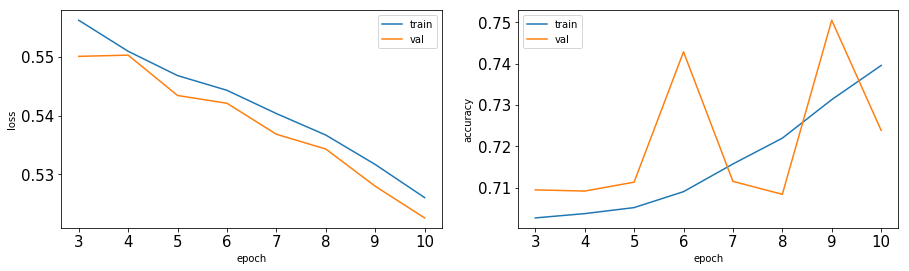

In [303]:
xstart = 2

xepochs = np.arange(len(classifier_losses_massonly))+1

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(xepochs[xstart:], classifier_losses_massonly[xstart:], label='train')
plt.plot(xepochs[xstart:], classifier_val_losses_massonly[xstart:], label='val')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend();

plt.subplot(122)
plt.plot(xepochs[xstart:], classifier_acc_massonly[xstart:], label='train')
plt.plot(xepochs[xstart:], classifier_val_acc_massonly[xstart:], label='val')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

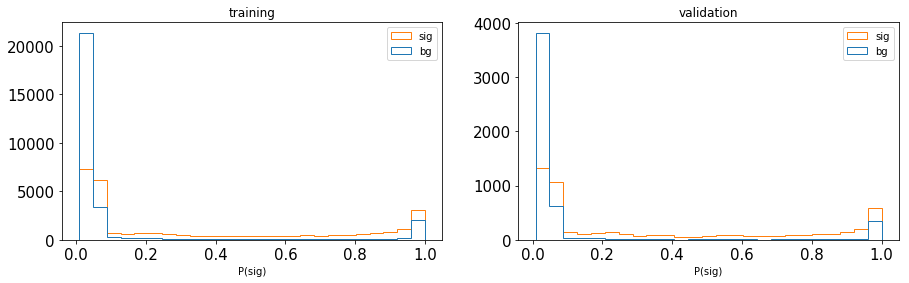

In [304]:
plt.figure(figsize=(15,4))

hargs = dict(histtype='step', bins=25, label=['bg','sig'])

plt.subplot(121)
plt.hist([model_massonly.predict(X_train[y_train==0])[:,1], model_massonly.predict(X_train[y_train==1])[:,1]], **hargs)
plt.xlabel("P(sig)")
plt.title("training")
plt.legend();

plt.subplot(122)
plt.hist([model_massonly.predict(X_val[y_val==0])[:,1], model_massonly.predict(X_val[y_val==1])[:,1]], **hargs)
plt.xlabel("P(sig)")
plt.title("validation")
plt.legend();

In [306]:
# pick a particular jet, and initialize the adversarial example with its values. also initialize the adversarial noise with zeros

njet = 6000
target_class = 0

use_sign = False

target_name = ['bg', 'signal'][target_class]
other_name = ['signal','bg'][target_class]

x_massonly = X_val[y_val==target_class][:njet]
x_adv_massonly = x_massonly.copy()
x_noise_massonly = np.zeros_like(x_massonly)

prediction_history_massonly     = [model_massonly.predict(x_massonly)[:,target_class].mean()]
prediction_history_quant_massonly = [np.percentile(model_massonly.predict(x_massonly)[:,target_class],100*np.array([0.5,0.68,0.95]))]

In [307]:
# Define the epsilons in the (pt, eta, phi) directions
epsilons = (5e-5,5e-4,5e-4)
nstep = 4

# Then loop for the desired number of iterations to update the adversarial
# noise using the classifier loss gradient:

sess = K.get_session()
epsilon = K.reshape(K.constant(epsilons), (1,1,3))
for istep in range(nstep):
    print("FGSM %d/%d..."%(istep+1,nstep))
    loss = -1*K.categorical_crossentropy(to_categorical((target_class+1)%2,2), model_massonly.get_output_at(0))
    grads = K.gradients(loss, model_massonly.get_input_at(0))
    
    if use_sign:
        delta = K.sign(grads[0])
    else:
        delta = grads[0]
    x_noise_massonly = x_noise_massonly + delta
    
    x_adv_massonly = x_adv_massonly + epsilon*delta
    x_adv_massonly = sess.run(x_adv_massonly, feed_dict={model_massonly.get_input_at(0):x_massonly})
    preds = model_massonly.predict(x_adv_massonly)[:,target_class]
    prediction_history_massonly.append(preds.mean())
    prediction_history_quant_massonly.append(np.percentile(preds, 100*np.array([0.5,0.68,0.9])))
    print("  avg:", preds.mean())

FGSM 1/4...
  avg: 0.12097353
FGSM 2/4...
  avg: 0.12296754
FGSM 3/4...
  avg: 0.12369976
FGSM 4/4...
  avg: 0.12409461


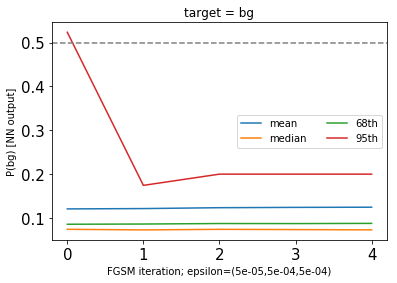

In [308]:
plt.plot(prediction_history_massonly, label='mean')
plt.plot(np.array(prediction_history_quant_massonly)[:,0], label='median')
plt.plot(np.array(prediction_history_quant_massonly)[:,1], label='68th')
plt.plot(np.array(prediction_history_quant_massonly)[:,2], label='95th')
plt.xlabel("FGSM iteration; epsilon=(%.e,%.e,%.e)"%epsilons)
plt.ylabel("P(%s) [NN output]"%target_name)
plt.title("target = %s"%target_name)
plt.axhline(0.5, ls='--', color='gray')
plt.legend(ncol=2);

In [111]:
def D2_layer(x):
    ecf1 = ecf_tf(1, 1, x, normalized=False)
    ecf2 = ecf_tf(2, 1, x, normalized=False)
    ecf3 = ecf_tf(3, 1, x, normalized=False)

    c2 = ecf3 * ecf1 / tf.square(ecf2)
    d2 = ecf3 * tf.pow(ecf1, 3) / tf.pow(ecf2, 3)

    return d2

In [112]:
#Now, let's FGSM D2.
#Let's start by making some ROC curves.

model_D2only = Sequential()
model_D2only.add(Lambda(D2_layer,input_shape=(32,3),output_shape=(1,)))
model_D2only.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_11 (Lambda)           (None, 1)                 0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [113]:
from sklearn.metrics import roc_curve, auc

In [115]:
preds = model_D2only.predict(X_train)

In [116]:
fpr, tpr, _ = roc_curve(y_train, preds)

In [129]:
preds_NN = classifier.predict(X_train)
fprNN, tprNN, _ = roc_curve(y_train, preds_NN[:,1])

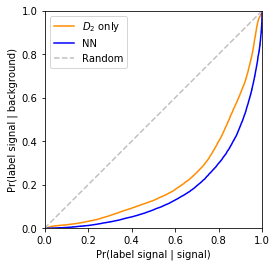

In [131]:
plt.axes().set_aspect('equal')
plt.plot(fpr,tpr,color='darkorange',label=r'$D_{2}$ only')
plt.plot(tprNN,fprNN,color='blue',label=r'NN')
plt.plot([0,1],[0,1],linestyle='--',color="#C0C0C0",label="Random")
plt.xlabel('Pr(label signal | signal)')
plt.ylabel('Pr(label signal | background)')
plt.axis([0, 1, 0, 1])
plt.legend(loc='upper left')
plt.show()

In [174]:
# pick a particular jet, and initialize the adversarial example with its values. also initialize the adversarial noise with zeros

njet = 6000
target_class = 0

use_sign = True

target_name = ['bg', 'signal'][target_class]
other_name = ['signal','bg'][target_class]

x_D2only = X_val[y_val==target_class][:njet]
x_adv_D2only = x_D2only.copy()
x_noise_D2only = np.zeros_like(x_D2only)

prediction_history_D2only     = [model_D2only.predict(x_D2only)[:,target_class].mean()]
prediction_history_quant_D2only = [np.percentile(model_D2only.predict(x_D2only)[:,target_class],100*np.array([0.5,0.68,0.95]))]

## Define the epsilons in the (pt, eta, phi) directions
#epsilons = (5e-5,5e-4,5e-4)
epsilons = (2e-4,2e-3,2e-3)
nstep = 10

# Then loop for the desired number of iterations to update the adversarial
# noise using the classifier loss gradient:

sess = K.get_session()
epsilon = K.reshape(K.constant(epsilons), (1,1,3))
for istep in range(nstep):
    print("FGSM %d/%d..."%(istep+1,nstep))
    loss = -1*K.categorical_crossentropy(to_categorical((target_class+1)%2,2), model_D2only.get_output_at(0))
    grads = K.gradients(loss, model_D2only.get_input_at(0))
    
    if use_sign:
        delta = K.sign(grads[0])
    else:
        delta = grads[0]
    x_noise_D2only = x_noise_D2only + delta
    
    x_adv_D2only = x_adv_D2only + epsilon*delta
    x_adv_D2only = sess.run(x_adv_D2only, feed_dict={model_D2only.get_input_at(0):x_D2only})
    preds = model_D2only.predict(x_adv_D2only)[:,target_class]
    prediction_history_D2only.append(preds.mean())
    prediction_history_quant_D2only.append(np.percentile(preds, 100*np.array([0.5,0.68,0.9])))
    print("  avg:", preds.mean())

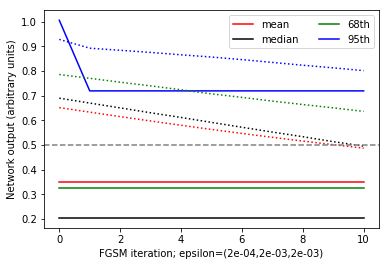

In [188]:
plt.plot(np.array(prediction_history_D2only)/12., label='mean',color='red')
plt.plot(np.array(prediction_history_quant_D2only)[:,0]/12., label='median',color='black')
plt.plot(np.array(prediction_history_quant_D2only)[:,1]/12., label='68th',color='green')
plt.plot(np.array(prediction_history_quant_D2only)[:,2]/12., label='95th',color='blue')

plt.plot(prediction_history,linestyle=":",color='red')
plt.plot(np.array(prediction_history_quant)[:,0],linestyle=":",color='black')
plt.plot(np.array(prediction_history_quant)[:,1],linestyle=":",color='green')
plt.plot(np.array(prediction_history_quant)[:,2],linestyle=":",color='blue')

plt.xlabel("FGSM iteration; epsilon=(%.e,%.e,%.e)"%epsilons)
plt.ylabel("Network output (arbitrary units)")
#plt.title("target = %s"%target_name)
plt.axhline(0.5, ls='--', color='gray')
plt.legend(ncol=2);

In [189]:
ecf1_adv = ecf_numpy(1, 1, x_adv_D2only, normalized=False)
ecf2_adv = ecf_numpy(2, 1, x_adv_D2only, normalized=False)
ecf3_adv = ecf_numpy(3, 1, x_adv_D2only, normalized=False)

In [190]:
d2_adv = ecf3_adv * pow(ecf1_adv, 3) / pow(ecf2_adv, 3)

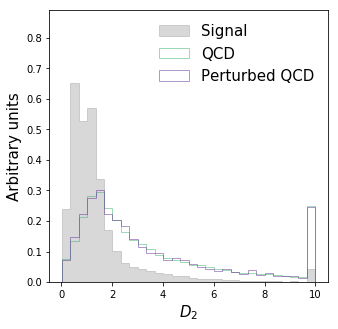

In [205]:


hargs = dict(histtype='step')
fig = plt.figure(figsize=(5,5))
n,b,_=plt.hist(np.clip(d2[y_train==1],0,10),bins=30,density=True, color='gray', fill='gray', alpha=0.3, label='Signal', **hargs)
n2,_,_=plt.hist(np.clip(d2[y_train==0],0,10),alpha=0.5,bins=b,density=True, label='QCD', **hargs,color='mediumseagreen')
plt.hist(np.clip(d2_adv,0,10),alpha=0.5,bins=b,density=True, label='Perturbed QCD', **hargs,color='rebeccapurple')
plt.xlabel(r"$D_{2}$",fontsize=15)
plt.ylabel("Arbitrary units",fontsize=15)
plt.ylim(top=plt.ylim()[1]*1.3)
plt.legend(fontsize=15,frameon=False);
fig.savefig("D2_FGSM.pdf");

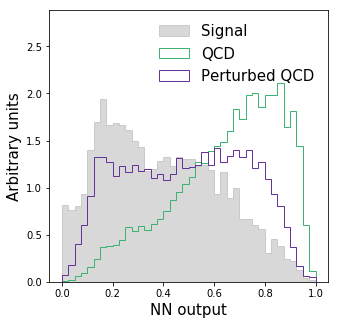

In [197]:
hargs = dict(histtype='step', bins=40, range=(0,1), density=True)

target_class=1
fig = plt.figure(figsize=(5,5))
plt.hist(classifier.predict(X_val[y_val!=target_class])[:,1], color='gray', fill='gray', alpha=0.3, label='Signal', **hargs)
plt.hist(classifier.predict(x)[:,1], label='QCD', **hargs,color='mediumseagreen')
plt.hist(classifier.predict(x_adv)[:,1], label='Perturbed QCD', **hargs,color='rebeccapurple')
plt.xlabel("NN output",fontsize=15)
plt.ylabel("Arbitrary units",fontsize=15)
plt.ylim(top=plt.ylim()[1]*1.3)
plt.legend(fontsize=15,frameon=False);
fig.savefig("NN_FGSM.pdf");